> ## 1. Building a Character Tokenizer

> ### 1.1. Taking a look at the data

In [1]:
with open("input.txt", 'r', encoding='utf-8') as file:
    text = file.read()
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"We have {vocab_size} unique characters in our vocabulary")

We have 65 unique characters in our vocabulary


> ### 1.2.  Encoder and Decoder (basic)

In [3]:
encoder = {ch:idx for idx, ch in enumerate(chars)}
decoder = {idx:ch for idx, ch in enumerate(chars)}

encode = lambda s: [encoder[c] for c in s]
decode = lambda l: ''.join([decoder[i] for i in l])

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

data = torch.tensor(encode(text), dtype=torch.long)

print(f"Shape of data: {data.shape}")
print(f"Datatype of tensor: {data.dtype}")

n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

Shape of data: torch.Size([1115394])
Datatype of tensor: torch.int64


> ### 1.3. Setting the ground

> #### 1.3.1. Hyperparameters

In [6]:
batch_size = 16
block_size = 32

max_iter = 2400
eval_iters = 200
eval_interval = 100

learning_rate = 1e-3

device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0

> #### 1.3.2. Generating batches

+ The `get_batch()` function
    + gets hold of the data
    + generates  `batch_size` number of offsets
    + generates a block from each offset
    + generates a shifted block from each offset
    + stacks these block into rows (each row is independent)

In [7]:
def get_batch(split):
    data = train_data if split == 'train' else val_data

    random_offsets = torch.randint(low=0, high=len(data) - block_size,
                                   size=(batch_size, ))

    x = torch.stack([data[idx:idx+block_size] for idx in random_offsets]).to(device)
    y = torch.stack([data[idx+1:idx+block_size+1] for idx in random_offsets]).to(device)
    return x, y

> ## 2. Implementing Self-Attention

> ### 2.1. Single Head Attention

+ Shape of `query`: (`batch_size`, `block_size`, `head_size`)
+ Shape of `key`: (`batch_size`, `block_size`, `head_size`)
+ Shape of `key.transpose(-2, -1)`: (`batch_size`, `head_size`, `block_size`)
<br><br>
+ Multiplication of `q` and `k.transpose(-2, -1)` (ignoring the batch dimension):
    + (`block_size`, `head_size`) . (`head_size`, `block_size`)
    + The multiplication will give the output of shape: (`block_size`, `block_size`) or (`T`, `T`)
<br><br>    
+ Multiplication of $\text{q} \ . \ \text{k}^\top$ and `v` (ignoring the batch dimension):
    + (`block_size`, `block_size`) . (`block_size`, `head_size`)
    + The multiplication will give the output of shape: (`block_size`, `head_size`)
<br><br>

+ **NOTE:**
    + `T` is used interchangeably with `block_size`
    + `C` is used interchangeably with `n_embed`
    + `head_size` denotes `n_embed` ÷ `n_head`

In [8]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape

        k = self.key(x)
        q = self.query(x)
        v = self.value(x)

        wei = q @ k.transpose(-2, -1) * C ** -0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        out = wei @ v
        return out

> ### 2.2. Multi Head Attention

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        out = self.dropout(out)
        return out

In [10]:
class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, n_embd),
            nn.ReLU(),
            nn.Linear(n_embd, n_embd),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        out = self.net(x)
        return out

> ### 2.4. Transformer Block Implementation

In [11]:
class Block(nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()

        self.sa = MultiHeadAttention(num_heads=n_head, head_size=(n_embd // n_heads))
        self.ffwd = FeedForward(n_embd=n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = self.ln1(x)
        x = x + self.sa(x)
        x = self.ln2(x)
        x = x + self.ffwd(x)
        return x

> ## 3. Language Model Implementation

+ Key Components
    + Token Embedding Table (`token_embedding_table`)
    <br><br>
    + Position Embedding Table (`position_embedding_table`)
    <br><br>
    + Transformer Blocks (`blocks`)
        + A sequence of transformer blocks defined by the Block class. Each block applies multi-head self-attention and feed-forward networks, allowing the model to learn complex relationships between tokens.
        <br><br>
    + Layer Normalization (`ln_f`)
    <br><br>
    + Output Linear Layer (lm_head)
    <br><br>

In [12]:
class LanguageModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.token_emebdding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd=n_embd, n_heads=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_embd = self.token_emebdding_table(idx)
        pos_embd = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_embd + pos_embd
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx =  torch.cat((idx, idx_next), dim=1)

        return idx

> ## 5. Training and Evaluating Loops
+ The `estimate_loss` function estimates the average loss on the training and validation splits without computing gradients (using `torch.no_grad( )` to save memory and computation) and returns a dictionary containing the mean losses for both splits.
<br><br>
<br><br>

> #### Training Loop
+ The training loop loops through a defined number of iterations (`max_iter`).
<br><br>
+ At every `eval_interval` iterations or at the last iteration, it estimates the loss using `estimate_loss( )` and prints the average training and validation losses.
+ It works by:
    + Sampling a batch of training data using `get_batch('train')`.
    + Computing the logits and loss from the model.
    + Resetting the gradients with `optimizer.zero_grad(set_to_none=True)`.
    + Performing backpropagation with `loss.backward( )`.
    + Updating the model parameters `with optimizer.step( )`.
<br><br>
<br><br>

> #### Generating New Tokens
+ It works by:
    + Initializing a context tensor of zeros, which acts as the starting input for the model.
    + Calling the `generate( )` method of the model to produce `max_new_tokens`.
    + Decoding the generated token indices into human-readable text using `decode( )`.

In [13]:
model = LanguageModel()
m = model.to(device=device)
num_of_model_parameters = sum(p.numel() for p in m.parameters())/1e6
print(f"The model has {num_of_model_parameters}" , 'M parameters')

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

tr_losses = []
val_losses = []
def train():
    for iter in range(max_iter):
        if iter % eval_interval == 0 or iter == max_iter - 1:
            losses = estimate_loss()
            tr_losses.append(losses['train'])
            val_losses.append(losses['val'])
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        xb, yb = get_batch('train')

        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

The model has 0.110657 M parameters


In [17]:
train()

step 0: train loss 4.3384, val loss 4.3531
step 100: train loss 2.7434, val loss 2.7627
step 200: train loss 2.5490, val loss 2.5485
step 300: train loss 2.4483, val loss 2.4555
step 400: train loss 2.3876, val loss 2.4030
step 500: train loss 2.3350, val loss 2.3361
step 600: train loss 2.2851, val loss 2.3016
step 700: train loss 2.2447, val loss 2.2735
step 800: train loss 2.2042, val loss 2.2202
step 900: train loss 2.1766, val loss 2.1989
step 1000: train loss 2.1608, val loss 2.1694
step 1100: train loss 2.1211, val loss 2.1529
step 1200: train loss 2.0937, val loss 2.1285
step 1300: train loss 2.0763, val loss 2.1154
step 1400: train loss 2.0706, val loss 2.1101
step 1500: train loss 2.0408, val loss 2.0907
step 1600: train loss 2.0187, val loss 2.0812
step 1700: train loss 2.0041, val loss 2.0722
step 1800: train loss 2.0016, val loss 2.0771
step 1900: train loss 1.9843, val loss 2.0515
step 2000: train loss 1.9730, val loss 2.0488
step 2100: train loss 1.9603, val loss 2.0368


In [18]:
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))


MENTEOMES:
Wile so the here wall our her on harel am?

DUCION VIWAREt:

GAUd:

ThaMast, Myrate uphers ois dighcion! alct your with till
theer brople ruphat teer a pie,
What irstinghsing crith have tirne.

PRULUTET:
My, sealk my to now witth wher
lid prepths the aatt. In ligge shaly; in my, wilk, at I up orctiven
lighting, I'll with on that thould thred;
see sookm say out his theree did deadiot a souks fraall rentie.

DUCARD:
Goive is a I you, cold yand with, ting upsle,
Rirst of
bie slard an she


> ### 5.1. Plotting loss curves

In [27]:
import matplotlib.pyplot as plt
def plot_losses():
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(tr_losses)), tr_losses, label='Train Loss', color='blue')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Iterations (x100)')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

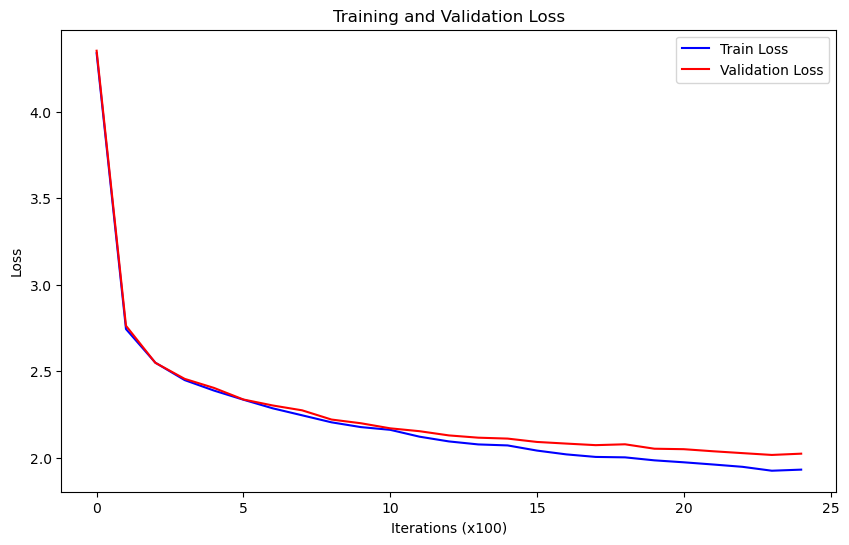

In [19]:
plot_losses()

In [ ]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))


Your ways, so affam, this ofor Aughors, am to thee;
Awary to: ay? busink'd feet!

Ning ELrows! my too his a brove, Eersthings,-mained doo belless:
Ghird grot pote arst your somele,
Nour bayw hiapker'q'eees eyitain them and castluce inbjuloke agonsty that.

Sourds your deassher toffuliks not forjed your
For ains tries igon the is getsaed falst orey lovind

That deages.


QUEEEN EOFored EDborg And Carplien ding for slon your to hath
s. May uters as and allows, the grield of and Gomodly Cay Cose is


> ## 6. Llama Style Decoder

> ### 6.1. Byte Pair Encoding (BPE) Implementation

> #### 6.1.1. Utility funtions

In [17]:
class BPE:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.num_merges = self.vocab_size - 256
        self.merges_map = {}
        self.byte_map = {}  

    def fit(self, text):
        utf_ids = text.encode('utf-8')
        utf_ids = list(map(int, utf_ids))
        
        new_utf_ids = utf_ids.copy()
        merges_map = {}
        for i in range(self.num_merges):
            pair_counts_dict = self.get_pair_counts_dict(new_utf_ids)
            if not pair_counts_dict:
                break
            max_count_pair = max(pair_counts_dict, key=pair_counts_dict.get)
            new_id = 256 + i
            new_utf_ids = self.merge_and_replace_pairs(new_utf_ids, max_count_pair, new_id)
            self.merges_map[max_count_pair] = new_id
        
        self.byte_map = {old_id: bytes([old_id]) for old_id in range(256)}

        for (id_1, id_2), new_id in self.merges_map.items():
            self.byte_map[new_id] = self.byte_map[id_1] + self.byte_map[id_2]
    
    @staticmethod
    def get_pair_counts_dict(utf_ids):
        counts = {}
        for pair in zip(utf_ids, utf_ids[1:]):
            counts[pair] = counts.get(pair, 0) + 1
        return counts

    @staticmethod
    def merge_and_replace_pairs(utf_ids, pair, new_id=256):
        new_utf_ids = []
        i = 0
        while i < len(utf_ids):
            if i < len(utf_ids) - 1 and utf_ids[i] == pair[0] and utf_ids[i + 1] == pair[1]:
                new_utf_ids.append(new_id)
                i += 2
            else:
                new_utf_ids.append(utf_ids[i])
                i += 1
        return new_utf_ids

    def encode(self, text):
        utf_ids = list(text.encode('utf-8'))
        while len(utf_ids) >= 2:
            pair_counts_dict = self.get_pair_counts_dict(utf_ids)
            pair = min(pair_counts_dict, key=lambda p: self.merges_map.get(p, float('inf')))
            if pair not in self.merges_map:
                break
            utf_id = self.merges_map[pair]
            utf_ids = self.merge_and_replace_pairs(utf_ids, pair, utf_id)
        return utf_ids

    def decode(self, encoded):
        return b"".join(self.byte_map[i] for i in encoded).decode('utf-8', errors='replace')

> ### 6.2. Modify the GPT Head to Use RoPE

In [22]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

        dim = head_size // 2
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, dtype=torch.float32) / dim))

        pos = torch.arange(0, block_size, dtype=torch.float32).unsqueeze(1)
        angles = pos * inv_freq

        self.register_buffer('cos', torch.cos(angles))
        self.register_buffer('sin', torch.sin(angles))

    def apply_rope(self, q, k, seq_len):
        cos = self.cos[:seq_len, :].unsqueeze(0)
        sin = self.sin[:seq_len, :].unsqueeze(0)

        q1, q2 = torch.chunk(q, 2, dim=-1)
        k1, k2 = torch.chunk(k, 2, dim=-1)

        q_rot = torch.cat([q1 * cos - q2 * sin, q1 * sin + q2 * cos], dim=-1)
        k_rot = torch.cat([k1 * cos - k2 * sin, k1 * sin + k2 * cos], dim=-1)

        return q_rot, k_rot

    def forward(self, x):
        B, T, C = x.shape

        k = self.key(x)
        q = self.query(x)
        v = self.value(x)

        wei = q @ k.transpose(-2, -1) * C ** -0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        out = wei @ v
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.w1 = nn.Linear(n_embd, n_embd)
        self.w2 = nn.Linear(n_embd, n_embd)
        self.w3 = nn.Linear(n_embd, n_embd)

    def forward(self, x):
        z = self.w1(x)
        swish_z = z * torch.sigmoid(z)
        g = self.w3(x)
        gated_output = swish_z * g
        out = self.w2(gated_output)
        return out
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        out = self.dropout(out)
        return out

class Block(nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.sa = MultiHeadAttention(num_heads=n_heads, head_size=(n_embd // n_heads))
        self.ffwd = FeedForward(n_embd=n_embd)
        self.ln1 = nn.RMSNorm(n_embd, eps=1e-8)
        self.ln2 = nn.RMSNorm(n_embd, eps=1e-8)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class LanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_emebdding_table = nn.Embedding(vocab_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd=n_embd, n_heads=n_head) for _ in range(n_layer)])
        self.ln_f = nn.RMSNorm(n_embd, eps=1e-8)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B,T = idx.shape
        tok_embd = self.token_emebdding_table(idx)
        x = tok_embd
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets == None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx =  torch.cat((idx, idx_next), dim=1)
        return idx

**Note: I am using a default vocabulary size such that the number of merges is limited to 128. This adjustment is because a vocabulary size of `5000` was taking too long to process on my laptop, as I am running the code locally without a GPU.** 
<br><br>

In [ ]:
bpe = BPE(vocab_size=256+128)
bpe.fit(text)
data = torch.tensor(bpe.encode(text), dtype=torch.long)

In [24]:
model = LanguageModel()
m = model.to(device=device)

In [25]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

tr_losses = []
val_losses = []
def train():
    for iter in range(max_iter):
        if iter % eval_interval == 0 or iter == max_iter - 1:
            losses = estimate_loss()
            tr_losses.append(losses['train'])
            val_losses.append(losses['val'])
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        xb, yb = get_batch('train')

        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

In [26]:
train()

step 0: train loss 4.3799, val loss 4.3810
step 100: train loss 2.7204, val loss 2.7418
step 200: train loss 2.5211, val loss 2.5316
step 300: train loss 2.4405, val loss 2.4376
step 400: train loss 2.3786, val loss 2.3824
step 500: train loss 2.3397, val loss 2.3320
step 600: train loss 2.2823, val loss 2.2844
step 700: train loss 2.2445, val loss 2.2433
step 800: train loss 2.2029, val loss 2.2317
step 900: train loss 2.1776, val loss 2.2056
step 1000: train loss 2.1483, val loss 2.1750
step 1100: train loss 2.1254, val loss 2.1669
step 1200: train loss 2.1000, val loss 2.1419
step 1300: train loss 2.0735, val loss 2.1076
step 1400: train loss 2.0602, val loss 2.1082
step 1500: train loss 2.0466, val loss 2.0807
step 1600: train loss 2.0180, val loss 2.0641
step 1700: train loss 2.0006, val loss 2.0596
step 1800: train loss 1.9740, val loss 2.0440
step 1900: train loss 1.9746, val loss 2.0394
step 2000: train loss 1.9571, val loss 2.0234
step 2100: train loss 1.9525, val loss 2.0264


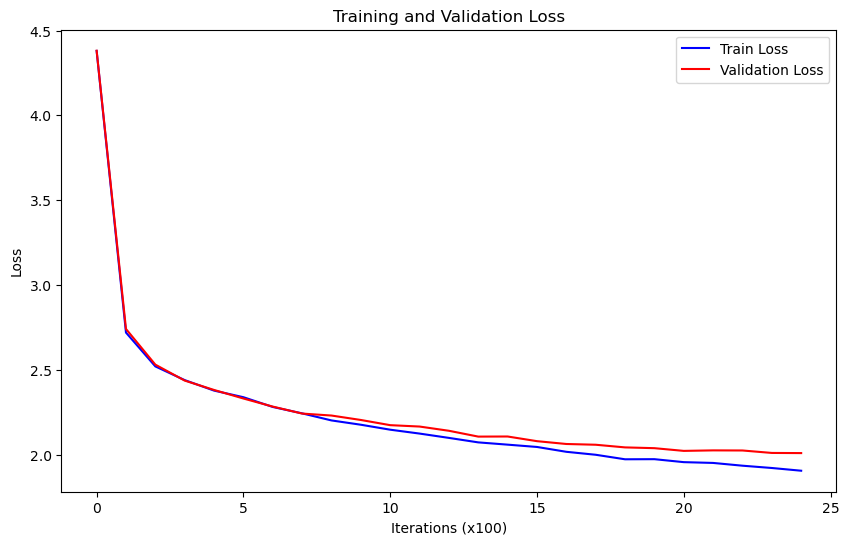

In [28]:
plot_losses()